In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#%timeit ,  line_profiler, memory_profiler

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from IPython.core.debugger import set_trace

nltk.download('wordnet')
stop = set(stopwords.words('spanish'))
stop.add('aunque')

[nltk_data] Downloading package wordnet to /Users/jordi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
import gensim.corpora as corpora

In [4]:
import logging
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)

In [24]:


df = pd.read_csv('data/66_REV_clean.csv')

In [25]:
df.head()

,book,chapter,verse,text,version
0,REV,1,1,"Esta es la revelación de Jesucristo, que Dios ...",NVI
1,REV,1,2,"quien por su parte da fe de la verdad, escribi...",NVI
2,REV,1,3,Dichoso el que lee y dichosos los que escuchan...,NVI
3,REV,1,4,"Yo, Juan, escribo a las siete iglesias que est...",NVI
4,REV,1,5,"y de parte de Jesucristo, el testigo fiel, el ...",NVI


In [26]:
class LDA_V():
    def __init__(self, pathfile):
        self.df = pd.read_csv(pathfile)
        self.df['tokens'] = df['text'].apply(self.process)
        print(self.df.tokens)
    
    def process(self, text):
        text = text.lower()
        text_filt = re.findall(r'\b[a-zA-Z]{3,}\b', text)

        wordnet_lemmatizer = WordNetLemmatizer()
        text_filt_le = [wordnet_lemmatizer.lemmatize(i) for i in text_filt]
        words_filt = [w for w in text_filt_le if w not in stop]
        return words_filt
    
ld = LDA_V('data/1_GEN_clean.csv')  

0       [jesucristo, dios, dio, mostrar, siervos, demo...
1       [parte, verdad, escribiendo, vio, saber, palab...
2       [dichoso, lee, dichosos, escuchan, palabras, m...
3       [juan, escribo, siete, iglesias, provincia, as...
4       [parte, jesucristo, testigo, fiel, soberano, r...
5       [hecho, reino, sacerdotes, servicio, dios, pad...
6       [mirad, viene, nubes, propios, ojos, incluso, ...
7          [alfa, omega, dice, dios, venir, todopoderoso]
8       [juan, hermano, sufrimiento, reino, perseveran...
9                           [vino, voz, fuerte, trompeta]
10      [escribe, libro, veas, siete, iglesias, esmirn...
11      [ver, voz, hablaba, volverme, siete, candelabr...
12      [medio, candelabros, alguien, semejante, hijo,...
13      [cabellera, lana, blanca, nieve, ojos, llama, ...
14      [pie, bronce, rojo, vivo, horno, voz, tan, fue...
15      [mano, derecha, siete, estrellas, boca, aguda,...
16      [verlo, pie, muerto, poniendo, mano, derecha, ...
17      [vive,

In [27]:
def process(text):
    text = text.lower()
    text_filt = re.findall(r'\b[a-zA-Z]{3,}\b', text)
    
    wordnet_lemmatizer = WordNetLemmatizer()
    text_filt_le = [wordnet_lemmatizer.lemmatize(i) for i in text_filt]
    words_filt = [w for w in text_filt_le if w not in stop]
    return words_filt

In [28]:
df['tokens'] = df['text'].apply(process)
print(df.tokens)

0      [jesucristo, dios, dio, mostrar, siervos, demo...
1      [parte, verdad, escribiendo, vio, saber, palab...
2      [dichoso, lee, dichosos, escuchan, palabras, m...
3      [juan, escribo, siete, iglesias, provincia, as...
4      [parte, jesucristo, testigo, fiel, soberano, r...
5      [hecho, reino, sacerdotes, servicio, dios, pad...
6      [mirad, viene, nubes, propios, ojos, incluso, ...
7         [alfa, omega, dice, dios, venir, todopoderoso]
8      [juan, hermano, sufrimiento, reino, perseveran...
9                          [vino, voz, fuerte, trompeta]
10     [escribe, libro, veas, siete, iglesias, esmirn...
11     [ver, voz, hablaba, volverme, siete, candelabr...
12     [medio, candelabros, alguien, semejante, hijo,...
13     [cabellera, lana, blanca, nieve, ojos, llama, ...
14     [pie, bronce, rojo, vivo, horno, voz, tan, fue...
15     [mano, derecha, siete, estrellas, boca, aguda,...
16     [verlo, pie, muerto, poniendo, mano, derecha, ...
17     [vive, muerto, ahora, vi

In [29]:
# prepare the corpus

def nltk_stopwords():
    return set(nltk.corpus.stopwords.words('english'))

def prep_corpus(docs, additional_stopwords=set(), no_below=3, no_above=0.5):
    print('Building dictionary...')
    dictionary = Dictionary(docs)
#     print(dictionary)
    stopwords = nltk_stopwords().union(additional_stopwords)
#     print(stopwords)
    stopword_ids = map(dictionary.token2id.get, stopwords)
#     print(stopword_ids)
    dictionary.filter_tokens(stopword_ids)
#     print(dictionary)
    dictionary.compactify()
#     print(dictionary)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
    print(dictionary)
    dictionary.compactify()
    
    print('Building corpus...')
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    return dictionary, corpus

In [30]:
dictionary, corpus = prep_corpus(df.tokens)

Building dictionary...
Dictionary(366 unique tokens: ['dar', 'dio', 'dios', 'jesucristo', 'juan']...)
Building corpus...


In [31]:
MmCorpus.serialize('bible.mm', corpus)
dictionary.save('bible.dict')

In [32]:
def lda(terms, num_topics_):
    dictionary = Dictionary(terms)
    texts = terms
    corpus = [dictionary.doc2bow(text) for text in texts]
    ldamod = models.ldamodel.LdaModel(corpus, 
               num_topics=num_topics_, 
               random_state=1,
               id2word = dictionary, 
               passes=50)

    return ldamod

In [33]:
#lda = lda(df.tokens,10)

In [34]:
lda_model = models.ldamodel.LdaModel(corpus=corpus,
         id2word=dictionary,
         num_topics=10,
         eval_every=10,
         passes=100,
         iterations=5000,
         random_state=np.random.RandomState(15))

<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<ipython-input-35-b67f90237044>:2: DeprecationWarning: invalid escape sequence \d
  p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")


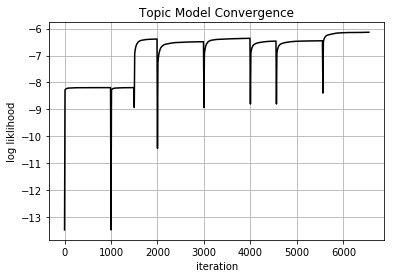

In [35]:

p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('gensim.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
liklihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter,liklihood,c="black")
plt.ylabel("log liklihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
#plt.savefig("convergence_liklihood.pdf")
#plt.close();
plt.show();

In [36]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis


In [37]:
#gensimvis.prepare(lda, corpus, dictionary)

vis_data1 = gensimvis.prepare(lda_model, corpus, dictionary)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [38]:
pyLDAvis.display(vis_data1)

In [39]:
pyLDAvis.save_html(vis_data1, 'ldavis.html')